# Computational Physics: Numerical Integrationn II
## The Biot-Savart Law
Class 15: 28 Feb 2024

<hr style="border-top: 1px solid purple; margin-top: 1px; border: 3px solid red"></hr>
Items for today:<br>
1. Questions on your code for numerical integration </br>
2. How to read an .xslx file or a .csv file</br>
3. Using Julia to compute the magnetic field of a current loop </br>

<hr style="margin-bottom: 1px; border: 3px solid red"></hr>  

## IMPORTS:

In [42]:
using CSV, DataFrames, CairoMakie
using MathTeXEngine, Dates
using PlotUtils: optimize_ticks
# configure nice fonts for Makie :-) :
textheme = Theme(fonts=(; regular=texfont(:text),
                        bold=texfont(:bold),
                        italic=texfont(:italic),
                        bold_italic=texfont(:bolditalic)));

## How to read a  .csv file
You'll want to first install XLSX.jl, CSV.jl, and DataFrames.jl in the usual manner. 
I'll add a few other packages we will eventually need.

```julia
(@v1.10) pkg>  add XLSX, CSV, DataFrames, Dates, PlotUtils
```
Tip: Instead of *ls*, to read the files in your current directory in the REPL, you type
```julia
julia>  readdir()
```
Let's see how to readin the file DataFile.csv. We'll use the DataFrames package:

In [43]:
df = DataFrame(CSV.File("DataFile.csv"))

Row,day,date,x,y
,Int64,String15,Float64,Int64?
1,1,26-Feb-24,94.57,missing
2,2,27-Feb-24,92.97,missing
3,3,28-Feb-24,91.84,104


To examine the individual columns, we use the .format:

In [44]:
df.date

3-element Vector{String15}:
 "26-Feb-24"
 "27-Feb-24"
 "28-Feb-24"

In [45]:
df.x

3-element Vector{Float64}:
 94.57
 92.97
 91.84

We'll see how to plot using dates later; for now, let's just see how to make a plot of the "x" column versus the day number:

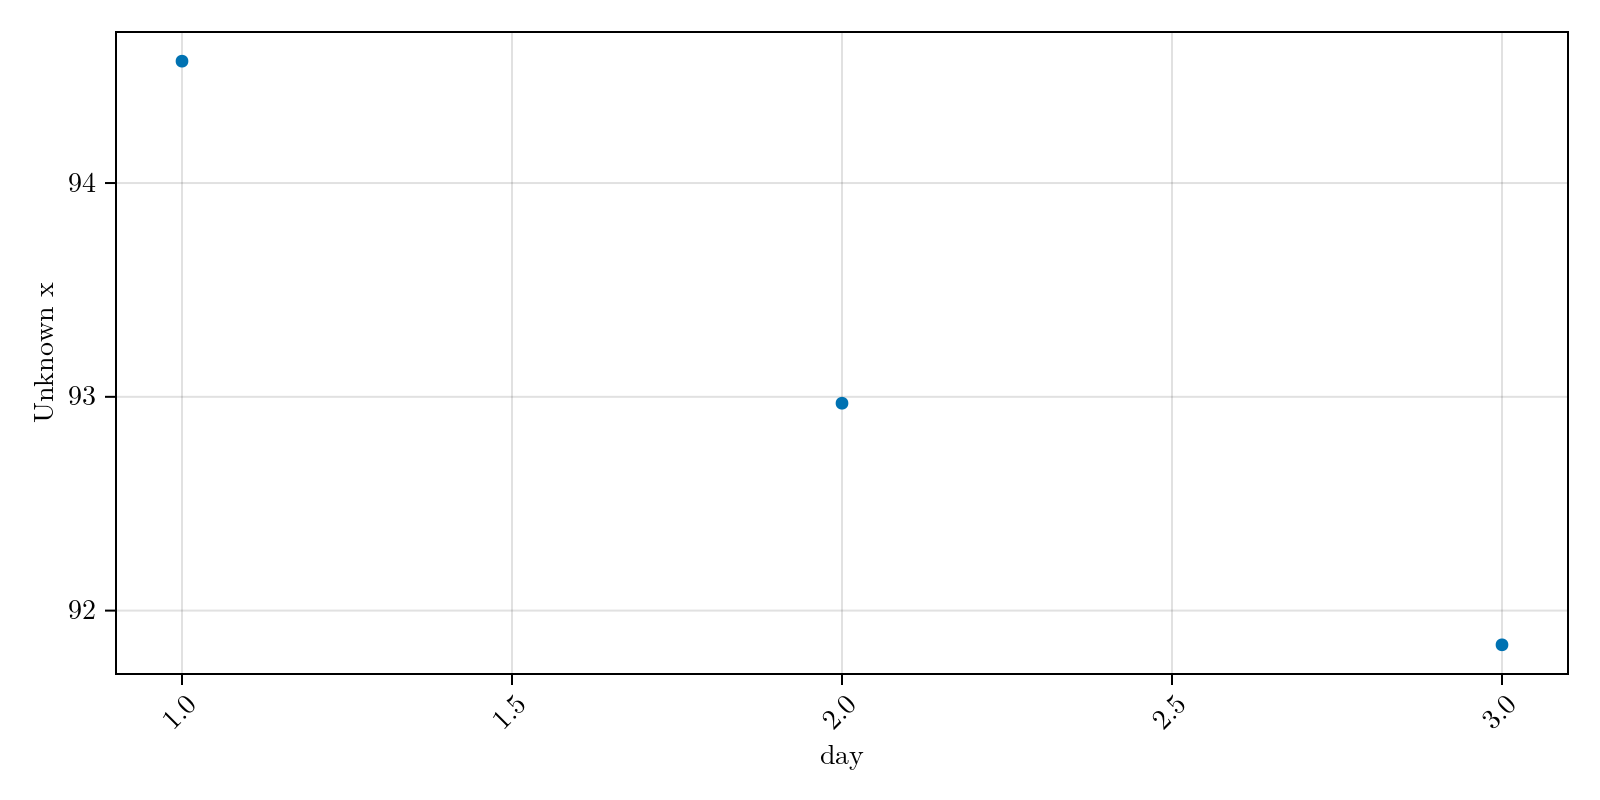

In [46]:
with_theme(textheme) do
fig = Figure(size=(800,400))
ax = Axis(fig[1,1])
scatter!(ax, df.day, df.x);
ax.xticklabelrotation = π/4
ax.xlabel = "day"
ax.ylabel = "Unknown x"
fig
end

## Using Julia to compute magnetic fields
In physics 123, you used the Biot-Savart law to compute the magnetic field; recall that the rule is 

$$d\mathbf{B} = \frac{\mu_o}{4\pi} \frac{\mathbf{I\,dl} \times \hat{r}}{r^2},$$

where $\mathbf{I\,dl}$ is an infinitesimal chunk of current (the source for the field) , and $\hat{r}$ is a unit vector which points 
*from the source* to the field point. Because it is not trivial to apply this formula except in cases with a high degree of symmetry, 
one only solves such "simple" cases analytically (although in upper level E&M classes, you do develop techniques to solve more challenging cases, but even these are limited to cases possessing symmetry.)

Today's class is about how to apply the Biot-Savart law to compute the magnetic field in general, and to do so, we will apply it to a case you've likely solved in Physics 123 --- the magnetic field created by a current loop. 
One of the things we will want to plot is a picture of the magnetic field perpendicular to the plane of the loop:

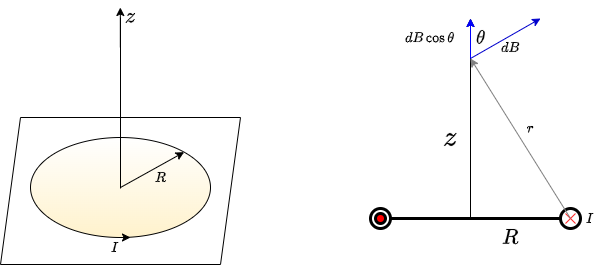

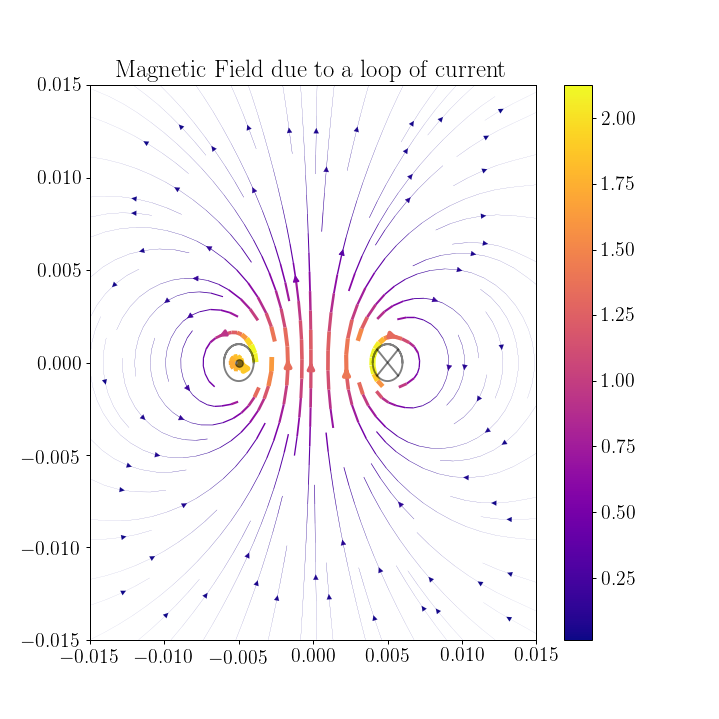

How can we compute the magnetic field in Julia? It's actually far simpler than doing the calculation manually 😃. It's simpler because it's easy to work with vectors in Julia using the ```LinearAlgebra``` package.

In [47]:
using LinearAlgebra

In [48]:
A = [1, 2, 3]
B = [1, 2, 0]
C = [2, 1, 0]
D = [0, 1, 0];

In [49]:
cross(A,B)


3-element Vector{Int64}:
 -6
  3
  0

In [50]:
cross(C,D)

3-element Vector{Int64}:
 0
 0
 2

Our vector $\vec{R}$ is given by

$$ \vec{R} = R(\cos\theta \hat{x} + \sin\theta\hat{y})$$

The current element, $\vec{Idl}$ is 

$$ \vec{Idl} = IR (-\sin\theta \hat{x} + \cos\theta \hat{y} )d\theta $$

The vector $\vec{r}$, which goes from the source ($Idl$) to the field point on the z-axis, can be obtained by noting that $\vec{R} + \vec{r} = \vec{z}$ so that 

$$ \vec{r} = \vec{z} - \vec{R}$$

In [51]:
μₒ = 1.2566370614359173e-6

1.2566370614359173e-6

In [52]:
function BonZ(z, N; I=1.0, R=1.0)
    Δθ = 2π/N
    B = [0.0, 0.0, 0.0]
    for θ in 0:Δθ:2π-Δθ
            Idl = I*R*[-sin(θ), cos(θ), 0]*Δθ
            r = [-R*cos(θ), -R*sin(θ), z]
            # compute "dB" without the μₒ/4π to save computation time
            dB = (μₒ/(4π))*cross(Idl, r)/(norm(r)^3)
            B = B .+ dB
    end
    B = 1.0e9*B # convert from T to nT
    return B
end    

BonZ (generic function with 1 method)

## On axis field remarks
For the special case of computing the field on-axis, the number of chunks you break up the integration into makes no difference.
You'll see this when you compute the field analytically on your next homework set. The plot below shows the magnetic field in the 
z direction when N=1000, as well as the difference between the computed field when N=10 and N=1000. Notice there is essentially zero 
difference between the two! This was initially suprising to me! But you'll soon see why in this special case, it makes perfect sense
:-).

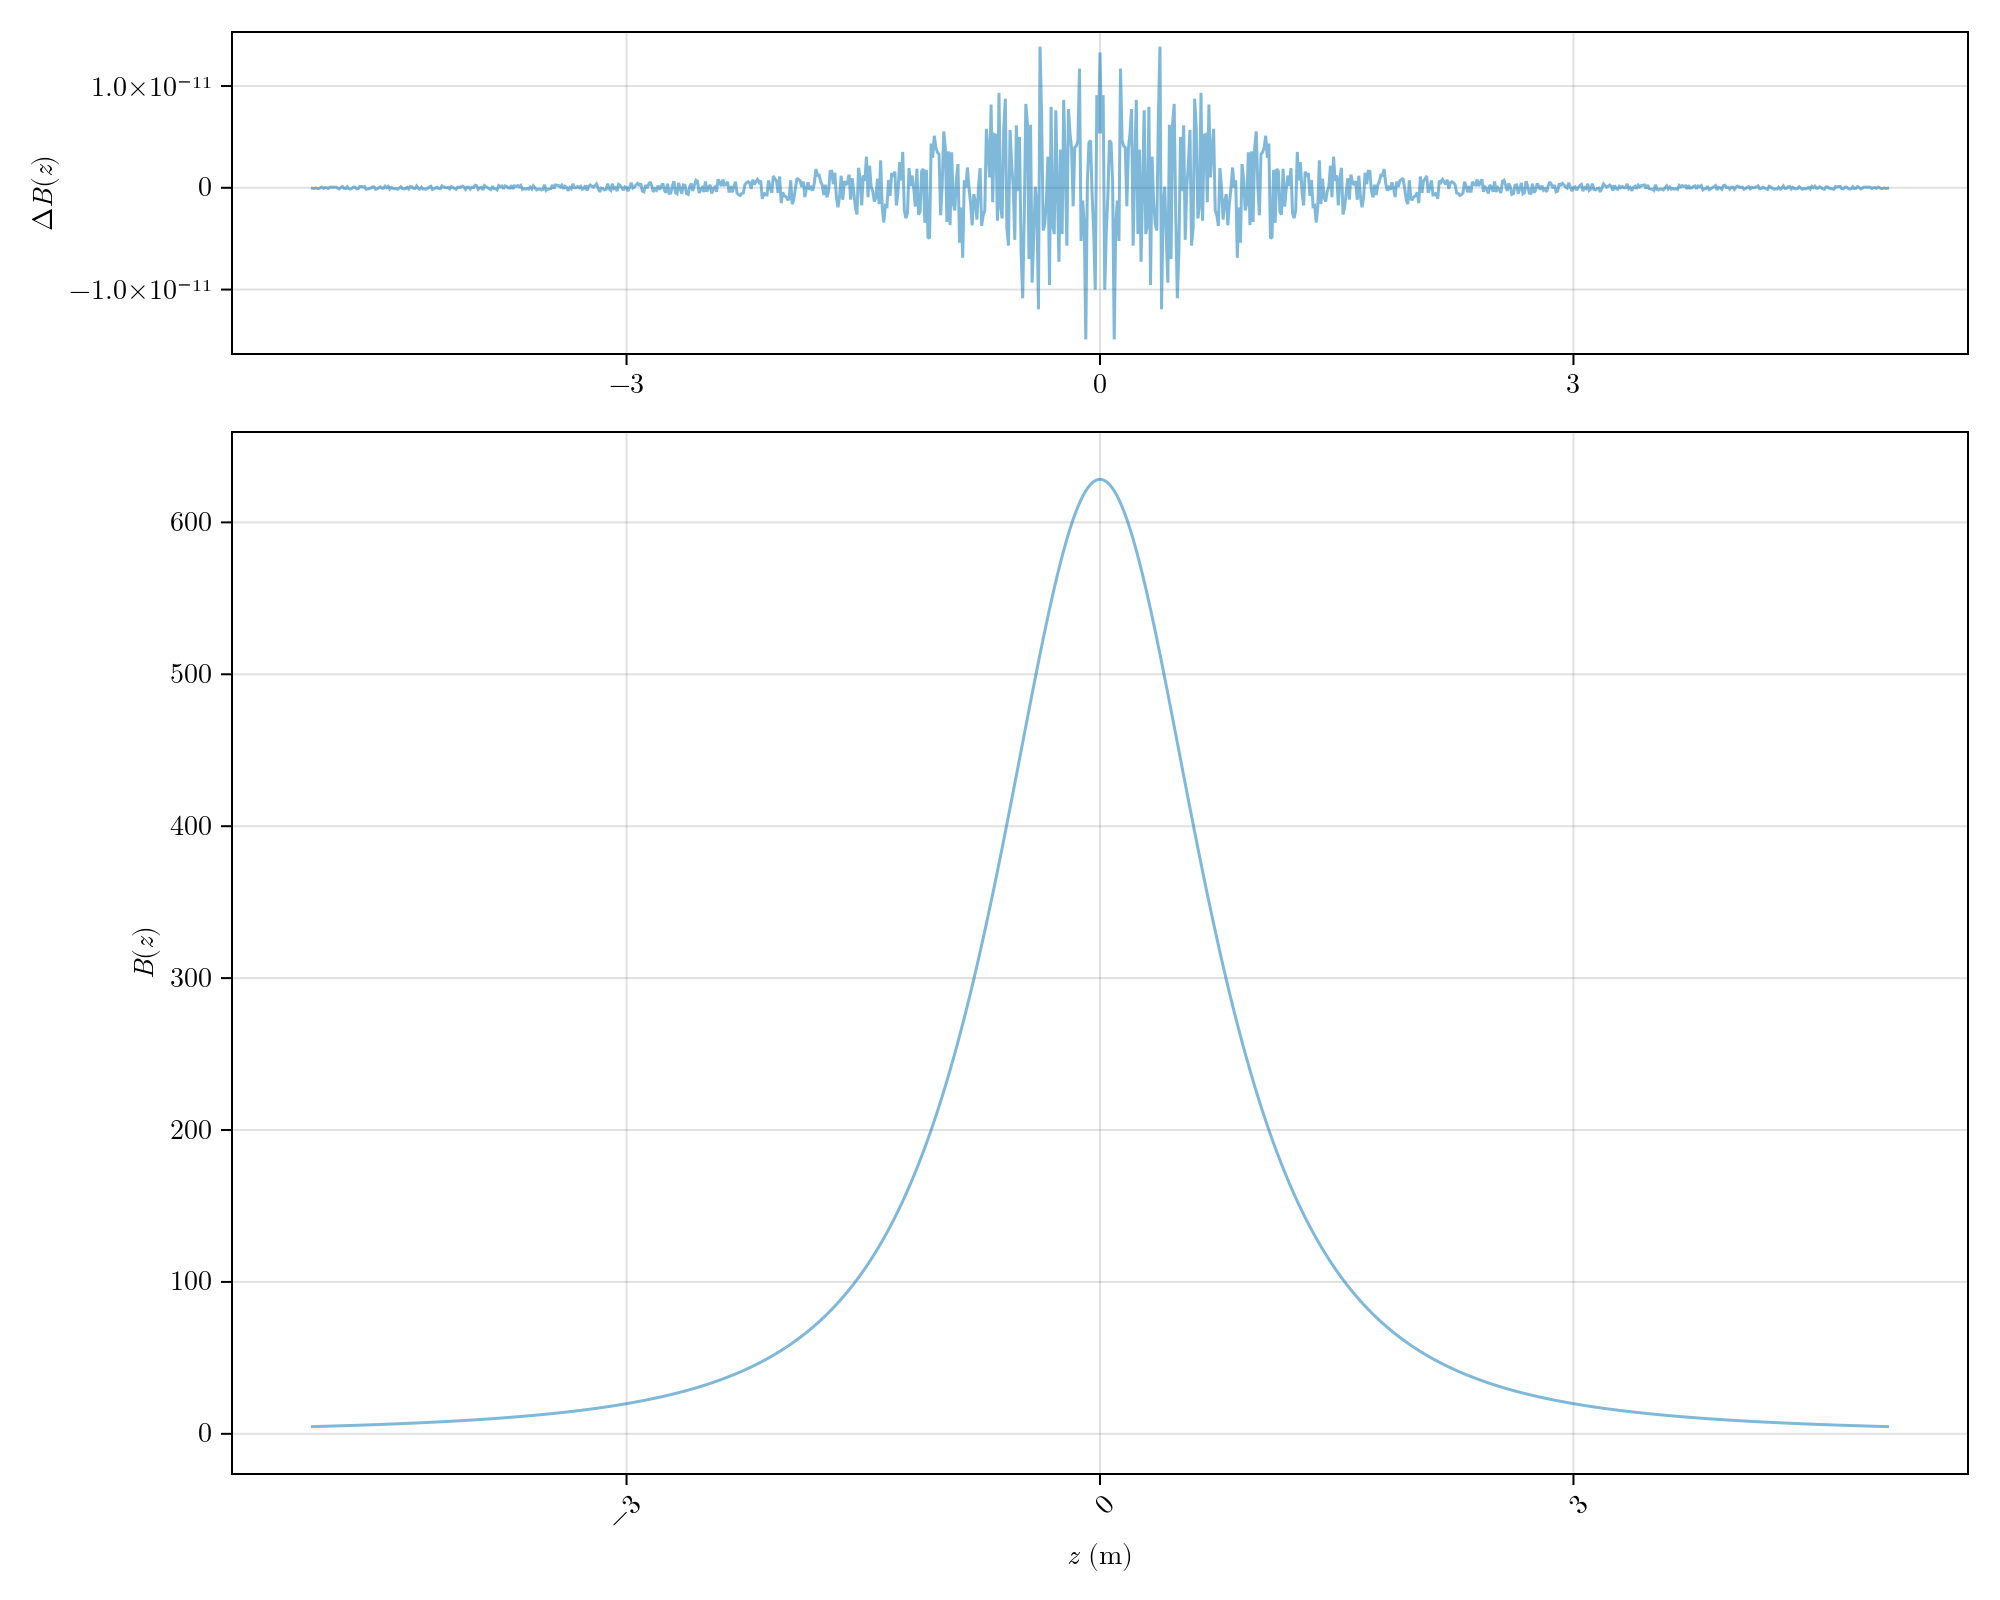

In [41]:
z = -5:0.01:5
Bz_1000 = [BonZ(zz,1000)[3]  for zz in z];
Bz_10 = [BonZ(zx,10)[3]  for zx in z];\
ΔB = Bz_1000 - Bz_10



with_theme(textheme) do
fig2 = Figure(size=(1000,800))

ax1 = Axis(fig2[1,1])
lines!(ax1, z, ΔB, alpha=0.5)
ax1.ylabel = L"$\Delta B(z)$"

ax2 = Axis(fig2[2:4,1])
lines!(ax2, z, Bz_1000, alpha = 0.5)  

ax2.xticklabelrotation = π/4
ax2.xlabel =L"$z$ (m)"
ax2.ylabel =L"$B(z)$"
fig2
end